**1. 스타뱅킹 리뷰 데이터에 대한 이해와 전처리**


In [ ]:
pip install konlpy

     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 448 kB 67.0 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1) 데이터 로드하기**

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 9398


In [ ]:
train_data[:5] # 상위 5개 출력

,document,label
0,You,1.0
1,"vip혜택,이벤트 등이 많고 디자인도 깔끔하고 보기에 편함",1.0
2,Vip고객입니다 너무편하고 좋아요,1.0
3,V50 쓰는데 로그인하면 계속팅김 사용하다 팅기면 참고하겠지만 로그인자체가 안됨 이...,0.0
4,v3실행하라더니 skt v3 유료결제 연동 뭡니까? 그리고 로그아웃은 대체 어딨습니까?,0.0


In [ ]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 1398


In [ ]:
test_data[:5]

,document,label
0,넘 편리해요~ 항상 잘 쓰고 있어요~^^,1
1,넘 편리하고 타행이체시 수수료도 없고 이체시 절차가 짧아 더욱 좋습니다.,1
2,넘 편리하고 좋아요 ♡,1
3,넘 편리하고 좋아요,1
4,넘 편리하고 신속정확해서 좋아요,1


**2) 데이터 정제하기**

In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()

(7470, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [ ]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 7471


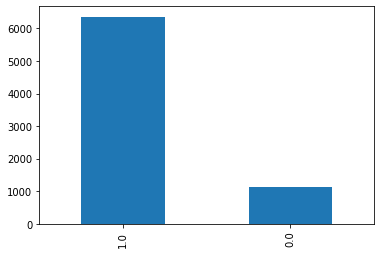

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0    0.0   1118
1    1.0   6352


In [ ]:
print(train_data.isnull().values.any())

True


In [ ]:
print(train_data.isnull().sum())

document    1
label       1
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()]

,document,label
8000,NaN,NaN


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [ ]:
print(len(train_data))

7470


In [ ]:
text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
re.sub(r'[^a-zA-Z ]', '', text) #알파벳과 공백을 제외하고 모두 제거

'do you expect people to read the FAQ etc and actually accept hard atheism'

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,document,label
0,,1.0
1,혜택이벤트 등이 많고 디자인도 깔끔하고 보기에 편함,1.0
2,고객입니다 너무편하고 좋아요,1.0
3,쓰는데 로그인하면 계속팅김 사용하다 팅기면 참고하겠지만 로그인자체가 안됨 이딴 쓰...,0.0
4,실행하라더니 유료결제 연동 뭡니까 그리고 로그아웃은 대체 어딨습니까,0.0


In [ ]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

document    26
label        0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()][:5]

,document,label
0,NaN,1.0
15,NaN,1.0
16,NaN,1.0
48,NaN,0.0
49,NaN,0.0


In [ ]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

7444


In [ ]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 1358


**3) 토큰화**

In [ ]:
#3.토큰화
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [ ]:
okt = Okt()
okt.morphs('와 이런 것도 앱라고 차라리 다른데서 만드는 게 나을 뻔', stem = True)

['오다',
 '이렇다',
 '것',
 '도',
 '앱',
 '라고',
 '차라리',
 '다른',
 '데',
 '서',
 '만들다',
 '게',
 '나다',
 '뻔']

In [ ]:
X_train = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
print(X_train[:3])

[['혜택', '이벤트', '등', '많다', '디자인', '깔끔하다', '보기', '편하다'], ['고객', '이다', '너무', '편하다', '좋다'], ['쓰다', '로그인', '계속', '팅기다', '사용', '팅기다', '참고', '로그인', '자체', '안되다', '이딴', '쓰레기', '어플', '만들다', '바', '다시', '만들다', '카카오', '무료', '수수료', '끝나다', '여기', '메인', '쓸리다', '햇', '늘다', '그지같다', '앱', '때문', '카카오', '계속', '쓴다', '싯팔']]


In [ ]:
X_test = []
for sentence in test_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

**4) 정수 인코딩**

In [ ]:
#4.정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [ ]:
print(tokenizer.word_index)

{'사용': 1, '있다': 2, '좋다': 3, '은행': 4, '편리하다': 5, '편하다': 6, '앱': 7, '자다': 8, '뱅킹': 9, '되다': 10, '을': 11, '하고': 12, '이용': 13, '어플': 14, '이체': 15, '스타': 16, '보다': 17, '되어다': 18, '국민은행': 19, '쓰다': 20, '로그인': 21, '너무': 22, '거래': 23, '없다': 24, '빠르다': 25, '쉬다': 26, '이다': 27, '같다': 28, '수': 29, '계좌': 30, '로': 31, '다른': 32, '중': 33, '인증서': 34, '간편하다': 35, '안되다': 36, '타': 37, '적': 38, '주': 39, '않다': 40, '많다': 41, '오류': 42, '에서': 43, '때': 44, '자주': 45, '불편하다': 46, '것': 47, '모바일': 48, '만': 49, '이벤트': 50, '안': 51, '없이': 52, '보기': 53, '업무': 54, '더': 55, '메뉴': 56, '다': 57, '요': 58, '기능': 59, '가능하다': 60, '이라': 61, '인증': 62, '까지': 63, '관리': 64, '계속': 65, '다양하다': 66, '화면': 67, '부터': 68, '등': 69, '정말': 70, '많이': 71, '등록': 72, '한눈': 73, '래': 74, '금융': 75, '항상': 76, '주거': 77, '나': 78, '만족하다': 79, '점': 80, '확인': 81, '아주': 82, '깔끔하다': 83, '하': 84, '넘다': 85, '잘쓰다': 86, '앞': 87, '인': 88, '오픈': 89, '받다': 90, '가다': 91, '구성': 92, '왜': 93, '조회': 94, '아니다': 95, '직관': 96, '내': 97, '인데': 98, '해주다': 99, '서비스': 100, '쓰기

In [ ]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 4801
등장 빈도가 2번 이하인 희귀 단어의 수: 2624
단어 집합에서 희귀 단어의 비율: 54.65528014996875
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.908437743328378


In [ ]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 2178


In [ ]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
print(X_train[:3])

[[236, 50, 69, 41, 194, 83, 53, 6], [162, 27, 22, 6, 3], [20, 21, 65, 582, 1, 582, 1110, 21, 265, 36, 1033, 394, 14, 114, 738, 121, 114, 674, 472, 203, 1455, 432, 401, 1614, 410, 1615, 7, 267, 674, 65, 1195, 1835]]


In [ ]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

**5) 빈 샘플 제거**

In [ ]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [ ]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

7438
7438


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


**6) 패딩**

리뷰의 최대 길이 : 146
리뷰의 평균 길이 : 14.752487227749395


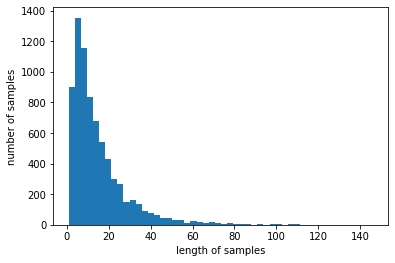

In [ ]:
#6. 패딩
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [ ]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 97.23043828986286


In [ ]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

**2. LSTM으로 스타뱅킹 리뷰 감성 분류하기**

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
100/100 [==============================] - 16s 125ms/step - loss: 0.2148 - acc: 0.9180 - val_loss: 0.1355 - val_acc: 0.9462

Epoch 00001: val_acc improved from -inf to 0.94624, saving model to best_model.h5
Epoch 2/15
100/100 [==============================] - 12s 118ms/step - loss: 0.0673 - acc: 0.9795 - val_loss: 0.0950 - val_acc: 0.9657

Epoch 00002: val_acc improved from 0.94624 to 0.96573, saving model to best_model.h5
Epoch 3/15
100/100 [==============================] - 12s 117ms/step - loss: 0.0520 - acc: 0.9857 - val_loss: 0.0983 - val_acc: 0.9610

Epoch 00003: val_acc did not improve from 0.96573
Epoch 4/15
100/100 [==============================] - 12s 116ms/step - loss: 0.0480 - acc: 0.9850 - val_loss: 0.1136 - val_acc: 0.9610

Epoch 00004: val_acc did not improve from 0.96573
Epoch 5/15
100/100 [==============================] - 12s 118ms/step - loss: 0.0409 - acc: 0.9882 - val_loss: 0.0963 - val_acc: 0.9671

Epoch 00005: val_acc improved from 0.96573 to 0.96707

In [ ]:
from sklearn.metrics import confusion_matrix
import torch
import numpy
y_train_pred = loaded_model(X_train)
y_train_pred = y_train_pred[:1358]
y_train_pred = np.around(y_train_pred)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89       161
           1       0.99      0.98      0.98      1197

    accuracy                           0.97      1358
   macro avg       0.92      0.96      0.94      1358
weighted avg       0.97      0.97      0.97      1358



**3. 리뷰 예측해보기**

In [ ]:
def sentiment_predict(new_sentence):
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [ ]:
sentiment_predict('이 앱 핵편함')

99.36% 확률로 긍정 리뷰입니다.



In [ ]:
sentiment_predict('앱 실화냐 너무 구린데')

93.68% 확률로 부정 리뷰입니다.



In [ ]:
sentiment_predict('속도')
sentiment_predict('이체')
sentiment_predict('환전')
sentiment_predict('인증')
sentiment_predict('이벤트')
sentiment_predict('송금')
sentiment_predict('UI')
sentiment_predict('편리')
sentiment_predict('브랜드')
sentiment_predict('이미지')

85.01% 확률로 긍정 리뷰입니다.

56.38% 확률로 긍정 리뷰입니다.

70.76% 확률로 긍정 리뷰입니다.

73.30% 확률로 부정 리뷰입니다.

98.52% 확률로 긍정 리뷰입니다.

67.21% 확률로 부정 리뷰입니다.

61.64% 확률로 부정 리뷰입니다.

90.43% 확률로 긍정 리뷰입니다.

61.64% 확률로 부정 리뷰입니다.

55.86% 확률로 긍정 리뷰입니다.



**4. 워드클라우드**

In [ ]:
from konlpy.tag import Hannanum

In [ ]:
# Google Colab matplotlib 한글 폰트 오류 문제 해결

# 1. 나눔 폰트 다운
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 2. 런타임 다시 시작

# matplotlib 한글 폰트 오류 문제 해결
from matplotlib import font_manager, rc
rc('font', family='AppleGothic')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [ ]:
extractor = Hannanum()

nouns = []
for text in train_data['document']:
  nouns.extend(extractor.nouns(text))

In [ ]:
from collections import Counter

count = Counter(nouns)
words = dict(count.most_common())
print(words.keys())

dict_keys(['사용', '편리', '수', '앱', '이용', '은행', '것', '국민은행', '스타뱅킹', '어플', '로그인', '이체', '주거래은행', '오류', '이벤트', '때', '주거래', '인증', '만족', '편', '로그', '계좌', '한눈', '가능', '메뉴', '기능', '간편', '저', '타은행', '직관적', '앞', '깔끔', '다양', '오픈뱅킹', '지문', '확인', '등', '한번', '중', '등록', '은행업무', '불편', '유용', '구성', '불편함', '업데이트', '관리', '서비스', '필요', '접속', '모바', '업무', '사용자', '빠른이체', '모바일인증서', '전', '데', '잘쓰', '눈', '점', '진짜', '조회', '생각', '듯', '뱅킹', '정보', '처리', '되', '최고', '개선', '해결', '패턴', '시간', '은행앱', '하나', '식', '감사', '개', '통합', '년', '화면', '국민', '뭐', '예전', '문제', '간단', '디자인', '잘사용하', '오랫동안', '거래', '속', '보안', '입출금', '나', '실행', '지금', '다른은행', '추천', '송금', '일', '애용', '가입', '다양한', '설치', '적금', '편리함', '수수료', '발급', '공인인증', '적', '후', '사용중', '입력', '복잡', '몇년', '화', '은행어플', '안전', '한', '정리', '혜택', '통장', '핸드폰', '로딩', '안정적', '이', '에러', '인터페이스', '안', '설정', '방식', 'ㅎㅎ', '방문', '삭제', '비밀번호', '처음', '번', '부분', '내', '카드', '발전', '고객', '스타뱅킹앱', '방법', '부탁드', '도', '여러가지', '번거', '불편한', '바', '진행', '먹통', '관련', '시', '사람', '무엇', '인터넷', '어디', '몇번', '기능들', '리

In [ ]:
import nltk
from wordcloud import WordCloud, STOPWORDS
stopwords = list(STOPWORDS) + (["것", "점", "말", "거", "때", "그", "내", "왜",
                                "나", "이", "뭐", "듯", "걸", "수", "더", "좀", "볼", 
                                "임", "개", "년", "암", "또", "안", "분", "중", "꼭"])
for word in list(words.keys()):
  if len(word) == 1:
    del words[word]
    continue
  if words[word] == 1:
    del words[word]

for word in stopwords:
  if word in words.keys():
    del words[word]

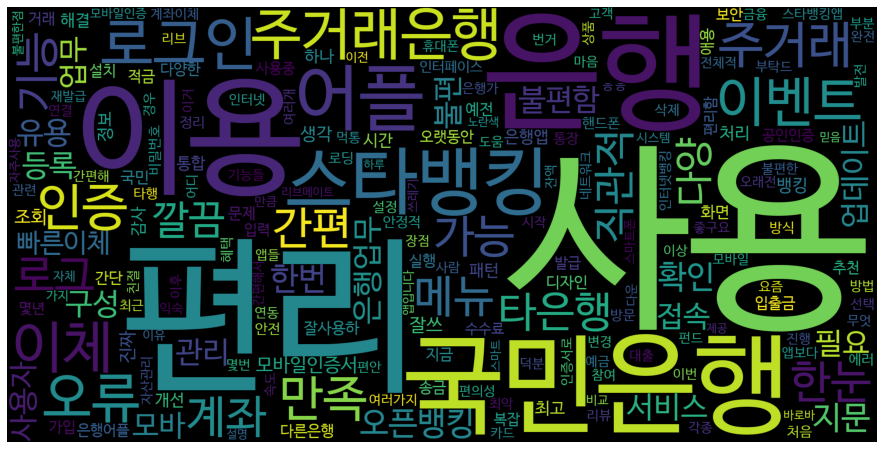

In [ ]:
wc = WordCloud(
    font_path ="NanumBarunGothic",
    width=2000,
    height=1000
).generate_from_frequencies(words)

plt.figure(figsize=(24, 8))
plt.imshow(wc)
plt.axis('off')
plt.show()